In [1]:
# =============================================================================
# 1) SETUP
# =============================================================================
from google.colab import drive
drive.mount('/content/drive')

# Install required packages
!pip install tensorflow keras opencv-python matplotlib seaborn shap lime scikit-image pyyaml

import os
import numpy as np
import tensorflow as tf
import shap
from lime import lime_image
import cv2
import matplotlib.pyplot as plt

from skimage.segmentation import slic
from tensorflow.keras.preprocessing.image import load_img, img_to_array

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 19.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=97908e11e6848a13ea561420f31a8718016fb2e8e1585cd2ad6508784a9daa64
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [3]:
# =============================================================================
# 2) CONFIGURATION & DATAFRAME
# =============================================================================
BASE_DIR       = '/content/drive/MyDrive/Fracatlas'
MODEL_PATH     = os.path.join(BASE_DIR, 'models', 'binary_model.h5')
IMG_SIZE       = (224,224)
BATCH_SIZE     = 32

# Build a simple DataFrame of test images + their YOLO label files
import pandas as pd
def build_test_df():
    img_dir = os.path.join(BASE_DIR, 'test', 'images')
    lbl_dir = os.path.join(BASE_DIR, 'test', 'labels')
    rows = []
    for fname in sorted(os.listdir(img_dir)):
        if not fname.lower().endswith(('.jpg','png','jpeg')): continue
        img_p = os.path.join(img_dir, fname)
        lbl_p = os.path.join(lbl_dir, fname.rsplit('.',1)[0] + '.txt')
        if os.path.exists(lbl_p) and os.path.getsize(lbl_p)>0:
            tokens = open(lbl_p).readline().split()
            # YOLO: class, x_center_norm, y_center_norm, w_norm, h_norm
            cls, xc, yc, w, h = tokens
            rows.append((img_p, lbl_p, int(cls),
                         float(xc), float(yc), float(w), float(h)))
    return pd.DataFrame(rows,
                        columns=['img','lbl','cls','xc','yc','w','h'])

df_test = build_test_df()
print("Test images with fractures:", len(df_test))

Test images with fractures: 61


In [4]:
# =============================================================================
# 3) LOAD THE TRAINED MODEL
# =============================================================================
binary_model = tf.keras.models.load_model(MODEL_PATH)
binary_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,637,315 (93.98 MB)

 Trainable params: 1,049,601 (4.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 2 (12.00 B)

In [5]:
# =============================================================================
# 4) EXPLANATION FUNCTIONS
# =============================================================================

# 4a) Grad-CAM
def get_gradcam(img_array):
    # find last conv layer
    for lyr in reversed(binary_model.layers):
        if isinstance(lyr, tf.keras.layers.Conv2D):
            last_conv = lyr.name
            break
    grad_model = tf.keras.models.Model(
        [binary_model.inputs],
        [binary_model.get_layer(last_conv).output, binary_model.output]
    )
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_array)
        idx   = tf.argmax(preds[0])
        loss  = preds[:,idx]
    grads = tape.gradient(loss, conv_out)
    pooled = tf.reduce_mean(grads, axis=(0,1,2))
    fmap   = conv_out[0]
    heat   = tf.tensordot(fmap, pooled, axes=[2,0])
    heat   = tf.maximum(heat,0) / (tf.math.reduce_max(heat)+1e-10)
    return heat.numpy()

In [6]:
# 4b) SHAP
# build a small background set
def get_shap_map(img_array, bg_np):
    expl = shap.GradientExplainer(
        (binary_model.input, binary_model.output),
        bg_np
    )
    vals = expl.shap_values(img_array[np.newaxis])[0][0]  # (224,224,3)
    m    = np.mean(np.abs(vals),axis=-1)
    return (m - m.min()) / (m.max()-m.min()+1e-10)

In [7]:
# 4c) LIME
def get_lime_map(raw_img):
    # raw_img in [0,1], shape (224,224,3)
    def pred_fn(batch):
        b = np.stack([cv2.resize(x,IMG_SIZE) for x in batch],0)
        b = tf.keras.applications.resnet50.preprocess_input(b*255.0)
        return binary_model.predict(b)
    expl = lime_image.LimeImageExplainer()
    exp  = expl.explain_instance(
        image=raw_img,
        classifier_fn=pred_fn,
        top_labels=1,
        hide_color=0,
        num_samples=1000,
        segmentation_fn=lambda x: slic(x, n_segments=200, compactness=10)
    )
    segs    = exp.segments
    weights = dict(exp.local_exp[exp.top_labels[0]])
    # build pixel-wise map
    M = np.zeros_like(segs, dtype=float)
    for seg_id,w in weights.items():
        M[segs==seg_id] = abs(w)
    return (M - M.min())/(M.max()-M.min()+1e-10)

In [8]:
# 4d) Saliency
def get_saliency_map(img_array):
    img_tf = tf.convert_to_tensor(img_array[np.newaxis],dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(img_tf)
        prob = binary_model(img_tf)[0][0]
    grads = tape.gradient(prob,img_tf)[0].numpy()
    M     = np.max(np.abs(grads),axis=-1)
    return (M - M.min())/(M.max()-M.min()+1e-10)

In [9]:
# =============================================================================
# 5) GT BBOX → MASK & METRIC FUNCTIONS
# =============================================================================

def bbox_to_mask(xc,yc,w,h, size=IMG_SIZE):
    """Convert normalized bbox to binary mask."""
    H,W = size
    cx,cy = xc*W, yc*H
    bw,bh = w*W, h*H
    x0 = int(max(0, cx - bw/2))
    y0 = int(max(0, cy - bh/2))
    x1 = int(min(W, cx + bw/2))
    y1 = int(min(H, cy + bh/2))
    M = np.zeros((H,W),dtype=bool)
    M[y0:y1, x0:x1] = True
    return M

def compute_iou(pred_mask, gt_mask):
    inter = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    return inter/union if union>0 else 0.0

def pointing_game(map_, gt_mask):
    y,x = np.unravel_index(np.argmax(map_), map_.shape)
    return bool(gt_mask[y,x])

In [13]:
# =============================================================================
# 6) EVALUATION LOOP (with safe resizing of every map)
# =============================================================================

# … (bg_np setup stays the same) …

results = {'gradcam':[], 'shap':[], 'lime':[], 'saliency':[]}

for idx, row in df_test.iterrows():
    # 1) load & preprocess
    raw = img_to_array(load_img(row.img, target_size=IMG_SIZE)) / 255.0
    inp = tf.keras.applications.resnet50.preprocess_input(raw * 255.0)

    # 2) compute “small” maps
    g_small   = get_gradcam(inp[np.newaxis])        # e.g. 7×7
    s_small   = get_saliency_map(inp)               # should be 224×224
    shap_small= get_shap_map(inp, bg_np)            # should be 224×224
    lime_small= get_lime_map(raw)                   # should be 224×224

    # 3) resize EVERYTHING to IMG_SIZE
    gmap   = cv2.resize(g_small,   IMG_SIZE, interpolation=cv2.INTER_LINEAR)
    smap   = cv2.resize(s_small,   IMG_SIZE, interpolation=cv2.INTER_LINEAR)
    shap_map= cv2.resize(shap_small,IMG_SIZE, interpolation=cv2.INTER_LINEAR)
    lime_map= cv2.resize(lime_small,IMG_SIZE, interpolation=cv2.INTER_LINEAR)

    # 4) build GT mask
    gt_mask = bbox_to_mask(row.xc, row.yc, row.w, row.h)

    # 5) threshold top 10% & compute metrics
    for name, M in [('gradcam',gmap),
                    ('shap',   shap_map),
                    ('lime',   lime_map),
                    ('saliency',smap)]:
        # boolean mask at same shape as gt_mask
        pmask = M >= np.percentile(M, 90)
        iou   = compute_iou(pmask, gt_mask)
        pg    = pointing_game(M, gt_mask)
        results[name].append((iou, pg))

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━

     method  mean_IoU  pointing_accuracy
0   gradcam  0.016862           0.016393
2      lime  0.013505           0.032787
1      shap  0.011163           0.032787
3  saliency  0.005906           0.016393

▶ Best technique: gradcam (IoU=0.017, PointingAcc=0.016)


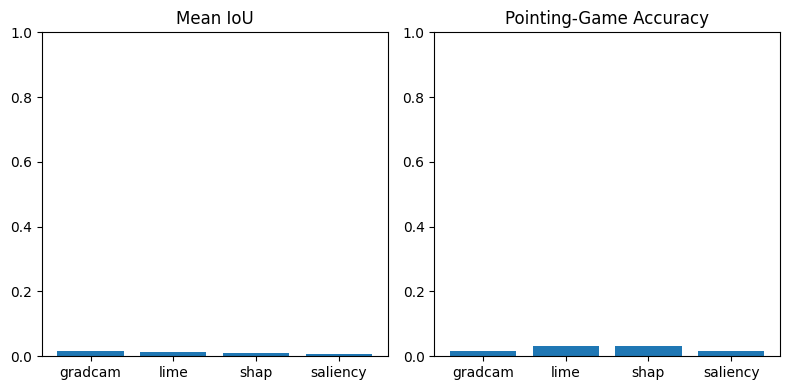

In [14]:
# =============================================================================
# 7) AGGREGATE & REPORT
# =============================================================================
import pandas as pd
summary = []
for name, vals in results.items():
    ious = [v[0] for v in vals]
    pgs  = [v[1] for v in vals]
    summary.append({
        'method':            name,
        'mean_IoU':          np.mean(ious),
        'pointing_accuracy': np.mean(pgs)
    })

df_sum = pd.DataFrame(summary).sort_values('mean_IoU', ascending=False)
print(df_sum)

best = df_sum.iloc[0]
print(f"\n▶ Best technique: {best.method} (IoU={best.mean_IoU:.3f}, "
      f"PointingAcc={best.pointing_accuracy:.3f})")

# Optional: bar plot
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.bar(df_sum.method, df_sum.mean_IoU)
plt.ylim(0,1)
plt.title('Mean IoU')

plt.subplot(1,2,2)
plt.bar(df_sum.method, df_sum.pointing_accuracy)
plt.ylim(0,1)
plt.title('Pointing-Game Accuracy')

plt.tight_layout()
plt.show()

In [18]:
# =============================================================================
# 7) DRAW A SMALL SAMPLE FOR COMPARISON
# =============================================================================
from tensorflow.keras.preprocessing.image import load_img, img_to_array

N = 5
sample_df    = df_test.sample(N, random_state=42).reset_index(drop=True)
sample_paths = sample_df['img'].tolist()
sample_images = [
    img_to_array(load_img(p, target_size=IMG_SIZE)) / 255.0
    for p in sample_paths
]
# (We no longer reference `binary_label`)

# =============================================================================
# 8) COMPUTE PRECISION & ACCURACY PER TECHNIQUE
# =============================================================================
results = {'Grad-CAM':[], 'LIME':[], 'SHAP':[], 'Saliency':[]}

for i in range(N):
    raw   = sample_images[i]    # (224,224,3) in [0,1]
    path  = sample_paths[i]
    row   = sample_df.iloc[i]
    gt    = bbox_to_mask(row.xc, row.yc, row.w, row.h, size=IMG_SIZE)

    # preprocess for model
    inp   = tf.keras.applications.resnet50.preprocess_input(raw * 255.0)

    # compute all four maps, resized to IMG_SIZE
    gmap   = cv2.resize(get_gradcam(inp[np.newaxis]),   IMG_SIZE)
    smap   = cv2.resize(get_saliency_map(inp),          IMG_SIZE)
    shap_map= cv2.resize(get_shap_map(inp, bg_np),      IMG_SIZE)
    lime_map= cv2.resize(get_lime_map(raw),             IMG_SIZE)

    # threshold top 10%
    thresh = lambda M: M >= np.percentile(M, 90)
    masks  = {
      'Grad-CAM': thresh(gmap),
      'LIME':     thresh(lime_map),
      'SHAP':     thresh(shap_map),
      'Saliency': thresh(smap),
    }

    # compute metrics
    for name, pmask in masks.items():
        tp  = np.logical_and(pmask, gt).sum()
        fp  = np.logical_and(pmask, ~gt).sum()
        tn  = np.logical_and(~pmask, ~gt).sum()
        fn  = np.logical_and(~pmask, gt).sum()
        precision = tp / (tp + fp + 1e-10)
        accuracy  = (tp + tn) / (tp + tn + fp + fn + 1e-10)
        results[name].append((precision, accuracy))

# =============================================================================
# 9) SUMMARIZE & PRINT
# =============================================================================
import pandas as pd

summary = []
for name, vals in results.items():
    precs = [v[0] for v in vals]
    accs  = [v[1] for v in vals]
    summary.append({
        'Technique':      name,
        'Mean Precision': np.mean(precs),
        'Mean Accuracy':  np.mean(accs),
    })

df_summary = pd.DataFrame(summary).sort_values('Mean Precision', ascending=False)
print(df_summary.to_string(index=False))

best = df_summary.iloc[0]
print(f"\n▶ Best by precision: {best['Technique']} "
      f"(Precision={best['Mean Precision']:.3f}, "
      f"Accuracy={best['Mean Accuracy']:.3f})")


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━

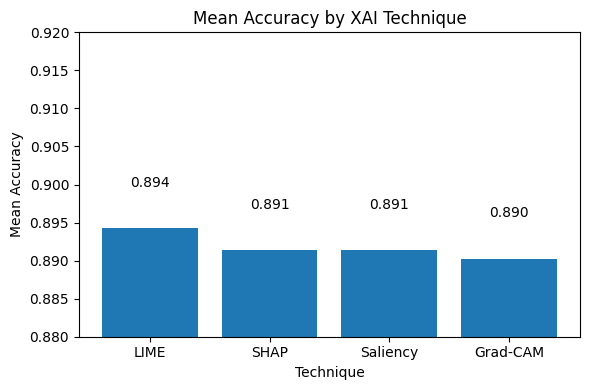

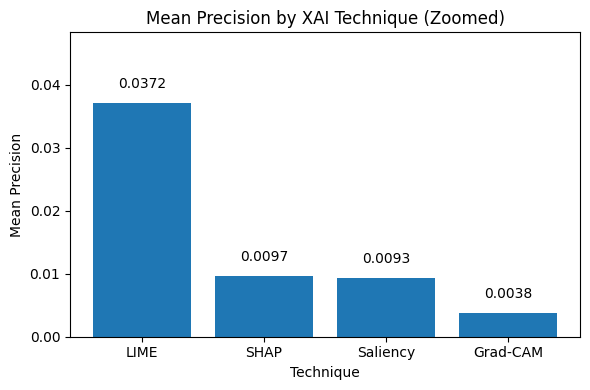

In [25]:
import matplotlib.pyplot as plt

# --- 1) Mean Accuracy (full range, annotated) ---
plt.figure(figsize=(6,4))
bars = plt.bar(df_summary['Technique'], df_summary['Mean Accuracy'])
plt.ylim(0.88, 0.92)                # zoom into [88%–92%] where your accuracies lie
plt.title('Mean Accuracy by XAI Technique')
plt.xlabel('Technique'); plt.ylabel('Mean Accuracy')
for bar in bars:
    y = bar.get_height()
    plt.text(bar.get_x()+bar.get_width()/2, y+0.005, f'{y:.3f}',
             ha='center', va='bottom')
plt.tight_layout()
plt.show()

# --- 2) Mean Precision (zoomed & annotated) ---
plt.figure(figsize=(6,4))
bars = plt.bar(df_summary['Technique'], df_summary['Mean Precision'])
max_p = df_summary['Mean Precision'].max()
plt.ylim(0, max_p*1.3)              # headroom above the top bar
plt.title('Mean Precision by XAI Technique (Zoomed)')
plt.xlabel('Technique'); plt.ylabel('Mean Precision')
for bar in bars:
    y = bar.get_height()
    plt.text(bar.get_x()+bar.get_width()/2, y+max_p*0.05, f'{y:.4f}',
             ha='center', va='bottom')
plt.tight_layout()
plt.show()